# Classifying Bonds as Overpriced or underpriced

Binary Classifcation of Bonds as overpriced or underpriced

author: Maris

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import datetime as dt
import os
import seaborn as sns
import random 
from scipy.optimize import newton
import itertools

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
sns.set_theme()
sns.set_palette("tab20")
sns.set_style("darkgrid", rc = {"grid.color": "white"})
c10 = sns.color_palette("tab10").as_hex()[:]
c20 = sns.color_palette("tab20").as_hex()[:]

In [5]:
pd.set_option('display.max_columns', None)
os.chdir('/Users/maris/Documents/FE800')

## Import Data

In [8]:
df = pd.read_pickle("factor_df.pkl")
df = df.drop(["92976GAJ0", "902613AY4", "64110LAT3", "64110LAS5"])
df.head()

Return      Price    volume    Trades       TTM  \
cusip     trd_dt                                                          
00206RBH4 2018-07-03  0.008850  86.513796 -0.785507 -0.940150  1.728678   
          2018-07-05  0.003406  86.808383 -0.573559  1.089431  1.724879   
          2018-07-06  0.004973  87.240021 -0.637707 -0.462601  1.722980   
          2018-07-09 -0.001021  87.150785 -0.115591 -0.940150  1.717283   
          2018-07-10  0.002972  87.409758 -0.519514 -0.462601  1.715383   

                      Stock_Return  Stock_Volume  ETF_Return        PV  \
cusip     trd_dt                                                         
00206RBH4 2018-07-03      0.015523     -0.171355   -0.005025  0.004849   
          2018-07-05     -0.003363     -0.086349    0.004959  0.001749   
          2018-07-06      0.002454      0.232636    0.007858  0.001668   
          2018-07-09      0.004123      0.357721    0.011967 -0.002931   
          2018-07-10      0.010887      0.103056    0.002150 -0.001502   

                           YTM  Duration      DV01  Convexity  
cusip     trd_dt                                               
00206RBH4 2018-07-03  0.902753  1.131115  0.498639   1.391850  
          2018-07-05  0.878724  1.132837  0.478094   1.392504  
          2018-07-06  0.841574  1.137649  0.447232   1.395884  
          2018-07-09  0.852737  1.113003  0.461360   1.375882  
          2018-07-10  0.830979  1.102112  0.447388   1.367151

In [9]:
macro_factors = pd.read_pickle("macro_factors.pkl").pct_change()
macro_factors = macro_factors.drop(["EFFR", "Lower_Target", "Upper_Target"], axis = 1)
macro_factors.head()

,1YRT,2YRT,3YRT,5YRT,7YRT,10YRT,30YRT,SPY,LQD
2018-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-03,-0.004274,-0.015564,-0.007547,-0.010909,-0.014134,-0.013937,-0.010033,-0.003531,0.003677
2018-07-05,-0.004292,0.007905,0.007605,0.007353,0.003584,0.003534,-0.003378,0.008158,0.003140
2018-07-06,0.008621,-0.007843,-0.003774,-0.010949,-0.007143,-0.007042,-0.003390,0.008458,0.001391
2018-07-09,0.000000,0.015810,0.007576,0.014760,0.014388,0.014184,0.006803,0.009004,0.000695


# Logistic Regression

In [10]:
train_prices = df[["Price"]].unstack("cusip").loc[pd.Timestamp("2022-06-01"):]
train_prices.head()

Price                                                          \
cusip       00206RBH4  00206RBK7  00206RCP5  00206RCQ3   00206RCU4  00206RDJ8   
trd_dt                                                                          
2022-06-01  93.696061  92.761184  99.776947  99.046467  112.546405  95.340660   
2022-06-02  93.085954  92.121467  99.372040  99.020972  112.546405  95.018561   
2022-06-03  92.672184  92.121467  99.191720  97.996980  111.007000  94.571000   
2022-06-06  91.239631  90.532671  98.354395  97.038563  112.082844  93.091566   
2022-06-07  91.475161  90.532671  98.635188  97.696183  110.653574  94.391726   

                                                                       \
cusip       00206RDK5   00206RDQ2   00206RDR0   002824BF6   002824BG4   
trd_dt                                                                  
2022-06-01  95.428238  101.978663  107.332423  102.275854  109.261822   
2022-06-02  95.428238  101.987713  107.404351  102.335711  109.279009   
2022-06-03  95.428238  101.756305  106.562702  102.228391  108.763289   
2022-06-06  94.164729  101.342162  106.312187  101.693400  107.981234   
2022-06-07  94.361329  101.407831  106.003077  101.867901  108.499000   

                                                                     \
cusip        002824BH2  00287YAM1   00287YAR0  00287YAS8  00287YAV1   
trd_dt                                                                
2022-06-01  110.207068  96.075494  100.827958  99.073745  98.268000   
2022-06-02  109.896280  95.529696  100.804925  98.852009  97.596523   
2022-06-03  109.287340  95.027000  100.064000  97.953991  97.578000   
2022-06-06  108.347295  94.851037   99.585116  97.953991  97.578000   
2022-06-07  108.347295  94.299571  100.118323  97.806913  97.449000   

                                                                    \
cusip       00287YAW9  00440EAW7  00774MAB1   00817YAF5  00817YAZ1   
trd_dt                                                               
2022-06-01  96.005746  97.770417  93.915000  118.445778  87.727014   
2022-06-02  96.042714  97.974550  93.915000  120.960870  87.727014   
2022-06-03  95.431112  97.974550  93.918000  118.159275  87.264107   
2022-06-06  95.068202  96.036000  93.923359  116.766207  86.480000   
2022-06-07  94.982610  97.397752  93.635991  117.520632  87.049000   

                                                                     \
cusip        013716AU9  02209SAM5  02209SAR4  02209SAV5   023135AP1   
trd_dt                                                                
2022-06-01  119.580000  80.631363  94.727850  75.278080  109.295983   
2022-06-02  119.434773  81.465901  93.325741  74.639940  108.829130   
2022-06-03  118.255000  80.258081  92.488223  75.028056  108.136209   
2022-06-06  118.255000  79.805196  92.559609  73.383536  108.885000   
2022-06-07  119.460000  80.595909  92.286895  74.123844  108.014462   

                                                                               \
cusip        023135AQ9  023135BC9  023135BF2  023135BJ4  023135BM7  025816BF5   
trd_dt                                                                          
2022-06-01  109.611712  98.657008  98.364479  98.563611  99.760887  94.501000   
2022-06-02  109.743166  98.624762  98.285568  98.348483  99.331863  94.501000   
2022-06-03  109.053937  98.595213  97.752373  97.695420  98.137561  94.232237   
2022-06-06  108.050327  98.174751  96.862468  96.876388  97.966207  93.099600   
2022-06-07  108.050327  98.325863  97.475853  96.576233  97.737131  93.499802   

                                                                     \
cusip        026874DF1   026874DL8  03027XAK6  03027XAP5  03040WAD7   
trd_dt                                                                
2022-06-01  100.830614  101.014980  96.662575  95.977719  120.66616   
2022-06-02  100.842840  101.387862  96.990692  95.875672  120.66616   
2022-06-03   99.664000  101.387862  96.648096  95.843504  120.66616   
2022-06-

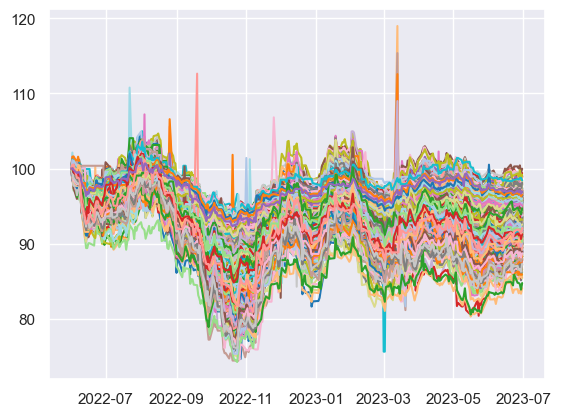

In [11]:
plt.plot(train_prices / train_prices.iloc[0] * 100)
plt.show()

In [12]:
train_returns = df[["Return"]].unstack("cusip").loc[pd.Timestamp("2022-06-01"):]
melted = train_returns.melt()
melted["Direction"] = melted["value"].apply(lambda x: 1 if x > 0 else 0)
len(melted[melted["Direction"] == 1])/ len(melted)

0.5366811345015987

In [13]:
df["Direction"] = df["Return"].apply(lambda x: 1 if x > 0 else 0)
df.head()

Return      Price    volume    Trades       TTM  \
cusip     trd_dt                                                          
00206RBH4 2018-07-03  0.008850  86.513796 -0.785507 -0.940150  1.728678   
          2018-07-05  0.003406  86.808383 -0.573559  1.089431  1.724879   
          2018-07-06  0.004973  87.240021 -0.637707 -0.462601  1.722980   
          2018-07-09 -0.001021  87.150785 -0.115591 -0.940150  1.717283   
          2018-07-10  0.002972  87.409758 -0.519514 -0.462601  1.715383   

                      Stock_Return  Stock_Volume  ETF_Return        PV  \
cusip     trd_dt                                                         
00206RBH4 2018-07-03      0.015523     -0.171355   -0.005025  0.004849   
          2018-07-05     -0.003363     -0.086349    0.004959  0.001749   
          2018-07-06      0.002454      0.232636    0.007858  0.001668   
          2018-07-09      0.004123      0.357721    0.011967 -0.002931   
          2018-07-10      0.010887      0.103056    0.002150 -0.001502   

                           YTM  Duration      DV01  Convexity  Direction  
cusip     trd_dt                                                          
00206RBH4 2018-07-03  0.902753  1.131115  0.498639   1.391850          1  
          2018-07-05  0.878724  1.132837  0.478094   1.392504          1  
          2018-07-06  0.841574  1.137649  0.447232   1.395884          1  
          2018-07-09  0.852737  1.113003  0.461360   1.375882          0  
          2018-07-10  0.830979  1.102112  0.447388   1.367151          1

In [14]:
def run_logistic_regression(df, feature, backtest = "False"):

    X = df.drop([feature, "Price", "Return"], axis = 1)[1:].fillna(0)
    Y = df[feature][1:].ffill()

    X_train = X.loc[:pd.Timestamp("2022-05-31")]
    X_test = X.loc[pd.Timestamp("2022-06-01"):]
    Y_train = Y.loc[:pd.Timestamp("2022-05-31")]
    Y_test = Y.loc[pd.Timestamp("2022-06-01"):]

    logistic_model = LogisticRegression()
    logistic_model.fit(X_train, Y_train)
    Y_pred = logistic_model.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    positive_predictions = (sum(Y_pred == 1) / len(Y_pred))

    return accuracy, precision, recall, positive_predictions

In [15]:
run_logistic_regression(pd.concat([df.loc[random.sample(list(df.index.droplevel(1).unique()), 1)[0]], 
                   macro_factors], axis = 1), "Direction")

(0.6457564575645757, 0.967741935483871, 0.24, 0.11439114391143912)

In [16]:
%%time

logistic_results = pd.DataFrame(columns = ["Cusip", "Accuracy", "Precision", "Recall", "Positive Prediction"])
for col in list(df.index.droplevel(1).unique()):
    outputs = run_logistic_regression(pd.concat([df.loc[col], macro_factors], axis = 1), "Direction")
    logistic_results.loc[len(logistic_results)] = [col, outputs[0], outputs[1], outputs[2], outputs[3]]

CPU times: user 4min 35s, sys: 13min 35s, total: 18min 11s
Wall time: 1min 51s


In [17]:
logistic_results.sort_values("Accuracy", ascending = True).head()

,Cusip,Accuracy,Precision,Recall,Positive Prediction
538,685218AB5,0.202952,0.474138,0.261905,0.428044
339,404280AJ8,0.250923,0.475177,0.341837,0.520295
80,049560AM7,0.269373,0.464516,0.385027,0.571956
368,452308AR0,0.280443,0.463415,0.415301,0.605166
367,444859BE1,0.284133,0.469512,0.418478,0.605166


In [18]:
logistic_results.drop(["Cusip"], axis = 1).mean(axis = 0)

Accuracy               0.544987
Precision              0.673581
Recall                 0.479747
Positive Prediction    0.453658
dtype: float64

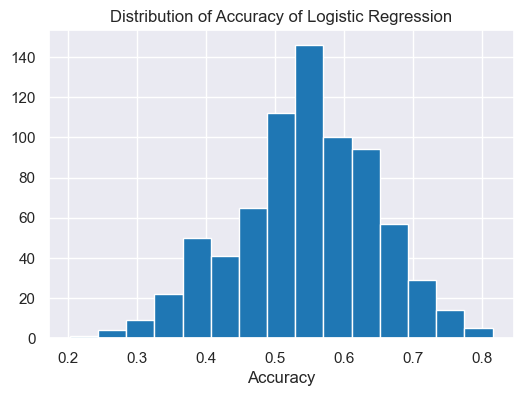

In [19]:
plt.figure(figsize = [6,4])

plt.hist(logistic_results["Accuracy"], bins = 15)
plt.title("Distribution of Accuracy of Logistic Regression")
plt.xlabel("Accuracy")

plt.show()

# Random Forest

In [20]:
def run_random_forest_classifier(df, feature, backtest = "False"):

    X = df.drop([feature, "Price", "Return"], axis = 1)[1:].fillna(0)
    Y = df[feature][1:].ffill()

    X_train = X.loc[:pd.Timestamp("2022-05-31")]
    X_test = X.loc[pd.Timestamp("2022-06-01"):]
    Y_train = Y.loc[:pd.Timestamp("2022-05-31")]
    Y_test = Y.loc[pd.Timestamp("2022-06-01"):]

    rf_model = RandomForestClassifier(n_estimators = 200)
    rf_model.fit(X_train, Y_train)
    Y_pred = rf_model.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    positive_predictions = (sum(Y_pred == 1) / len(Y_pred))

    return accuracy, precision, recall, positive_predictions

In [21]:
run_random_forest_classifier(pd.concat([df.loc[random.sample(list(df.index.droplevel(1).unique()), 1)[0]], 
                   macro_factors], axis = 1), "Direction")

(0.7970479704797048,
 0.8391959798994975,
 0.8789473684210526,
 0.7343173431734318)

In [22]:
%%time

rf_results = pd.DataFrame(columns = ["Cusip", "Accuracy", "Precision", "Recall", "Positive Prediction"])
for col in list(df.index.droplevel(1).unique()):
    outputs = run_random_forest_classifier(pd.concat([df.loc[col], macro_factors], axis = 1), "Direction")
    rf_results.loc[len(rf_results)] = [col, outputs[0], outputs[1], outputs[2], outputs[3]]

CPU times: user 4min 6s, sys: 1.94 s, total: 4min 8s
Wall time: 4min 8s


In [23]:
rf_results.head()

,Cusip,Accuracy,Precision,Recall,Positive Prediction
0,00206RBH4,0.763838,0.815789,0.683824,0.420664
1,00206RBK7,0.719557,0.758621,0.647059,0.428044
2,00206RCP5,0.793358,0.788618,0.763780,0.453875
3,00206RCQ3,0.745387,0.798165,0.649254,0.402214
4,00206RCU4,0.760148,0.808290,0.847826,0.712177


In [24]:
rf_results.drop(["Cusip"], axis = 1).mean()

Accuracy               0.759832
Precision              0.819802
Recall                 0.703706
Positive Prediction    0.464078
dtype: float64

# Support Vector Machine

In [25]:
def run_svc_classifier(df, feature, kernel = "linear", degree = 0):

    X = df.drop([feature, "Price", "Return"], axis = 1)[1:].fillna(0)
    Y = df[feature][1:].ffill()

    X_train = X.loc[:pd.Timestamp("2022-05-31")]
    X_test = X.loc[pd.Timestamp("2022-06-01"):]
    Y_train = Y.loc[:pd.Timestamp("2022-05-31")]
    Y_test = Y.loc[pd.Timestamp("2022-06-01"):]

    if kernel == "poly":
        svc = SVC(kernel = kernel, degree = degree)
    else:
        svc = SVC(kernel = kernel)
    svc.fit(X_train, Y_train)
    Y_pred = svc.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    positive_predictions = (sum(Y_pred == 1) / len(Y_pred))

    return accuracy, precision, recall, positive_predictions

In [27]:
%%time

svc_linear_results = pd.DataFrame(columns = ["Cusip", "Accuracy", "Precision", "Recall", "Positive Prediction"])
for col in list(df.index.droplevel(1).unique()):
    outputs = run_svc_classifier(pd.concat([df.loc[col], macro_factors], axis = 1), "Direction")
    svc_linear_results.loc[len(svc_linear_results)] = [col, outputs[0], outputs[1], outputs[2], outputs[3]]

CPU times: user 16.4 s, sys: 145 ms, total: 16.6 s
Wall time: 16.6 s


In [28]:
svc_linear_results.head()

,Cusip,Accuracy,Precision,Recall,Positive Prediction
0,00206RBH4,0.505535,0.750000,0.022059,0.014760
1,00206RBK7,0.520295,1.000000,0.044118,0.022140
2,00206RCP5,0.645756,0.969697,0.251969,0.121771
3,00206RCQ3,0.531365,1.000000,0.052239,0.025830
4,00206RCU4,0.678967,0.678967,1.000000,1.000000


In [29]:
svc_linear_results.drop(["Cusip"], axis = 1).mean()

Accuracy               0.597476
Precision              0.680784
Recall                 0.657526
Positive Prediction    0.600786
dtype: float64

In [30]:
run_svc_classifier(pd.concat([df.loc[random.sample(list(df.index.droplevel(1).unique()), 1)[0]], 
                   macro_factors], axis = 1), "Direction", kernel = "poly", degree = 2)

(0.6974169741697417, 0.6974169741697417, 1.0, 1.0)

In [31]:
%%time

svc_poly2_results = pd.DataFrame(columns = ["Cusip", "Accuracy", "Precision", "Recall", "Positive Prediction"])
for col in list(df.index.droplevel(1).unique()):
    outputs = run_svc_classifier(pd.concat([df.loc[col], macro_factors], axis = 1), "Direction", kernel = "poly", degree = 2)
    svc_poly2_results.loc[len(svc_poly2_results)] = [col, outputs[0], outputs[1], outputs[2], outputs[3]]

CPU times: user 14.9 s, sys: 96.9 ms, total: 15 s
Wall time: 15 s


In [32]:
svc_poly2_results.head()

,Cusip,Accuracy,Precision,Recall,Positive Prediction
0,00206RBH4,0.476015,0.488372,0.926471,0.952030
1,00206RBK7,0.490775,0.496124,0.941176,0.952030
2,00206RCP5,0.483395,0.470588,0.818898,0.815498
3,00206RCQ3,0.468635,0.480000,0.895522,0.922509
4,00206RCU4,0.678967,0.678967,1.000000,1.000000


In [33]:
svc_poly2_results.drop(["Cusip"], axis = 1).mean()

Accuracy               0.530878
Precision              0.540492
Recall                 0.877585
Positive Prediction    0.875012
dtype: float64

In [34]:
%%time

svc_poly3_results = pd.DataFrame(columns = ["Cusip", "Accuracy", "Precision", "Recall", "Positive Prediction"])
for col in list(df.index.droplevel(1).unique()):
    outputs = run_svc_classifier(pd.concat([df.loc[col], macro_factors], axis = 1), "Direction", kernel = "poly", degree = 3)
    svc_poly3_results.loc[len(svc_poly3_results)] = [col, outputs[0], outputs[1], outputs[2], outputs[3]]

CPU times: user 17.8 s, sys: 122 ms, total: 17.9 s
Wall time: 17.9 s


In [35]:
svc_poly3_results.head()

,Cusip,Accuracy,Precision,Recall,Positive Prediction
0,00206RBH4,0.509225,0.666667,0.044118,0.033210
1,00206RBK7,0.494465,0.400000,0.014706,0.018450
2,00206RCP5,0.538745,0.520833,0.196850,0.177122
3,00206RCQ3,0.557196,0.659091,0.216418,0.162362
4,00206RCU4,0.678967,0.678967,1.000000,1.000000


In [36]:
svc_poly3_results.drop(["Cusip"], axis = 1).mean()

Accuracy               0.573315
Precision              0.588555
Recall                 0.564874
Positive Prediction    0.530818
dtype: float64

In [37]:
%%time

svc_sigmoid_results = pd.DataFrame(columns = ["Cusip", "Accuracy", "Precision", "Recall", "Positive Prediction"])
for col in list(df.index.droplevel(1).unique()):
    outputs = run_svc_classifier(pd.concat([df.loc[col], macro_factors], axis = 1), "Direction", kernel = "sigmoid")
    svc_sigmoid_results.loc[len(svc_sigmoid_results)] = [col, outputs[0], outputs[1], outputs[2], outputs[3]]

CPU times: user 16.4 s, sys: 142 ms, total: 16.5 s
Wall time: 16.6 s


In [38]:
svc_sigmoid_results.head()

,Cusip,Accuracy,Precision,Recall,Positive Prediction
0,00206RBH4,0.490775,0.480000,0.176471,0.184502
1,00206RBK7,0.498155,0.500000,0.632353,0.634686
2,00206RCP5,0.494465,0.421875,0.212598,0.236162
3,00206RCQ3,0.516605,0.508982,0.634328,0.616236
4,00206RCU4,0.671587,0.731707,0.815217,0.756458


In [39]:
svc_sigmoid_results.drop(["Cusip"], axis = 1).mean()

Accuracy               0.506461
Precision              0.544476
Recall                 0.523317
Positive Prediction    0.522699
dtype: float64

In [40]:
%%time

svc_rbf_results = pd.DataFrame(columns = ["Cusip", "Accuracy", "Precision", "Recall", "Positive Prediction"])
for col in list(df.index.droplevel(1).unique()):
    outputs = run_svc_classifier(pd.concat([df.loc[col], macro_factors], axis = 1), "Direction", kernel = "rbf")
    svc_rbf_results.loc[len(svc_rbf_results)] = [col, outputs[0], outputs[1], outputs[2], outputs[3]]

CPU times: user 17.5 s, sys: 103 ms, total: 17.6 s
Wall time: 17.6 s


In [41]:
svc_rbf_results.head()

,Cusip,Accuracy,Precision,Recall,Positive Prediction
0,00206RBH4,0.464945,0.479452,0.772059,0.808118
1,00206RBK7,0.542435,0.551724,0.470588,0.428044
2,00206RCP5,0.457565,0.449495,0.700787,0.730627
3,00206RCQ3,0.520295,0.518868,0.410448,0.391144
4,00206RCU4,0.682657,0.681481,1.000000,0.996310


In [42]:
svc_rbf_results.drop(["Cusip"], axis = 1).mean()

Accuracy               0.560413
Precision              0.641818
Recall                 0.366859
Positive Prediction    0.317274
dtype: float64

In [43]:
compare_error_SVC = pd.DataFrame(columns = ["Accuracy", "Precision", "Recall", "Positive Prediction"])
compare_error_SVC.loc["Linear"] = np.mean(svc_linear_results.drop(["Cusip"], axis = 1), axis = 0)
compare_error_SVC.loc["Poly (Degree = 2)"] = np.mean(svc_poly2_results.drop(["Cusip"], axis = 1), axis = 0)
compare_error_SVC.loc["Poly (Degree = 3)"] = np.mean(svc_poly3_results.drop(["Cusip"], axis = 1), axis = 0)
compare_error_SVC.loc["Sigmoid"] = np.mean(svc_sigmoid_results.drop(["Cusip"], axis = 1), axis = 0)
compare_error_SVC.loc["Radial Basis"] = np.mean(svc_rbf_results.drop(["Cusip"], axis = 1), axis = 0)
compare_error_SVC = compare_error_SVC.rename(columns = {"R2 Test": "Test R2"})
compare_error_SVC

,Accuracy,Precision,Recall,Positive Prediction
Linear,0.597476,0.680784,0.657526,0.600786
Poly (Degree = 2),0.530878,0.540492,0.877585,0.875012
Poly (Degree = 3),0.573315,0.588555,0.564874,0.530818
Sigmoid,0.506461,0.544476,0.523317,0.522699
Radial Basis,0.560413,0.641818,0.366859,0.317274


# Naive Bayes

In [44]:
def run_gnb_classifier(df, feature):

    X = df.drop([feature, "Price", "Return"], axis = 1)[1:].fillna(0)
    Y = df[feature].iloc[1:].ffill()

    X_train = X.loc[:pd.Timestamp("2022-05-31")]
    X_test = X.loc[pd.Timestamp("2022-06-01"):]
    Y_train = Y.loc[:pd.Timestamp("2022-05-31")]
    Y_test = Y.loc[pd.Timestamp("2022-06-01"):]
    
    gnb = GaussianNB()
    gnb.fit(X_train, Y_train)
    Y_pred = gnb.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    positive_predictions = (sum(Y_pred == 1) / len(Y_pred))

    return accuracy, precision, recall, positive_predictions

In [45]:
run_gnb_classifier(pd.concat([df.loc[random.sample(list(df.index.droplevel(1).unique()), 1)[0]], 
                   macro_factors], axis = 1), "Direction")

(0.46863468634686345,
 0.8541666666666666,
 0.2303370786516854,
 0.17712177121771217)

In [46]:
%%time

gnb_results = pd.DataFrame(columns = ["Cusip", "Accuracy", "Precision", "Recall", "Positive Prediction"])
for col in list(df.index.droplevel(1).unique()):
    outputs = run_gnb_classifier(pd.concat([df.loc[col], macro_factors], axis = 1), "Direction")
    gnb_results.loc[len(gnb_results)] = [col, outputs[0], outputs[1], outputs[2], outputs[3]]

CPU times: user 2.73 s, sys: 65.7 ms, total: 2.8 s
Wall time: 2.8 s


In [47]:
gnb_results.head()

,Cusip,Accuracy,Precision,Recall,Positive Prediction
0,00206RBH4,0.634686,0.862745,0.323529,0.188192
1,00206RBK7,0.660517,0.866667,0.382353,0.221402
2,00206RCP5,0.782288,0.861702,0.637795,0.346863
3,00206RCQ3,0.730627,0.821053,0.582090,0.350554
4,00206RCU4,0.653137,0.741935,0.750000,0.686347


In [48]:
gnb_results.drop(["Cusip"], axis = 1).mean()

Accuracy               0.648703
Precision              0.857495
Recall                 0.430118
Positive Prediction    0.277383
dtype: float64

# Compare Methods

In [49]:
compare_error = pd.DataFrame(columns = ["Accuracy", "Precision", "Recall", "Positive Prediction"])
compare_error.loc["Logistic Regression"] = np.mean(logistic_results.drop(["Cusip"], axis = 1), axis = 0)
compare_error.loc["Linear SVC"] = np.mean(rf_results.drop(["Cusip"], axis = 1), axis = 0)
compare_error.loc["Random Forest"] = np.mean(svc_linear_results.drop(["Cusip"], axis = 1), axis = 0)
compare_error.loc["Naive Bayes"] = np.mean(gnb_results.drop(["Cusip"], axis = 1), axis = 0)
compare_error.T

,Logistic Regression,Linear SVC,Random Forest,Naive Bayes
Accuracy,0.544987,0.759832,0.597476,0.648703
Precision,0.673581,0.819802,0.680784,0.857495
Recall,0.479747,0.703706,0.657526,0.430118
Positive Prediction,0.453658,0.464078,0.600786,0.277383
